# Jul 21st, 2022 (Fig-2 OCs; K=7; n=128)

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Fig dir

In [2]:
nn = 128
perc = 20
fig_dir = 'Fig2_OCs'
fig_dir = pjoin(fig_base_dir, 'paper2.0', f'n{nn}-p{perc}', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n128-p20/Fig2_OCs

## Prepare (512)

In [3]:
num_k = 7
mice = Mice(nn)

## Results

In [4]:
final_perm={4: 6, 5: 4, 6: 5}
final_perm = {
    i: final_perm.get(i, i)
    for i in range(num_k)
}

In [5]:
%%time

results = similiarity_results(
    mice=mice,
    perc=perc,
    num_k=num_k,
    merge_thres=0.376,
    n_resamples=int(1e4),
    final_perm=final_perm,
)
bt = BootStrap(**results['props_ca'])
list(results)

CPU times: user 1min 33s, sys: 4.58 s, total: 1min 38s
Wall time: 1min 38s


[
    'bt_dict',
    'props_bo',
    'props_ca',
    'pi_sorted',
    'sim',
    'sim_b',
    'sim_overall',
    'sim_overall_b',
    'good_runs',
    'data4perm',
    'tests'
]

## Save dir

In [6]:
save_dir = pjoin(fig_dir, f"K{num_k}")
os.makedirs(save_dir, exist_ok=True)
print(save_dir)

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n128-p20/Fig2_OCs/K7

## OCs

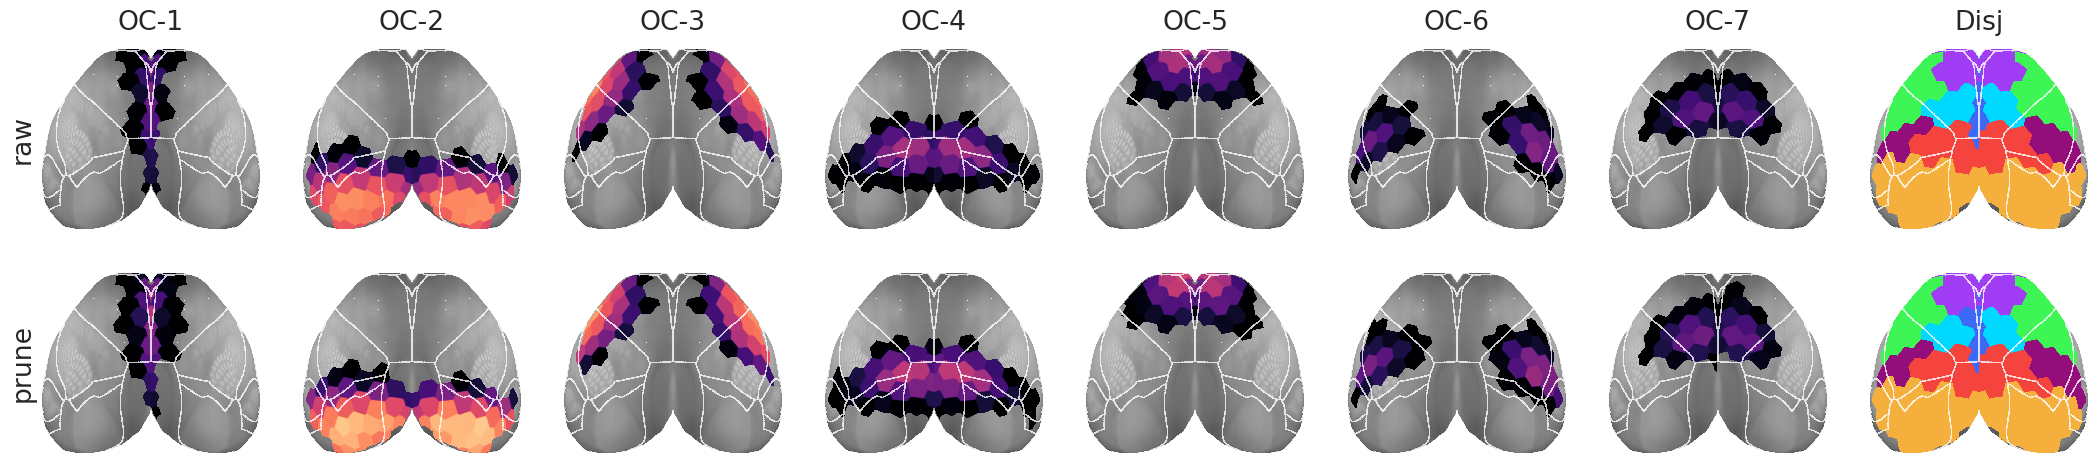

In [7]:
_ = bt.show(
    data={
        'raw': avg(results['bt_dict'][BOLD].run_pi),
        'prune': avg(results['bt_dict'][BOLD].pi_prune)},
    **show_kws(num_k),
)

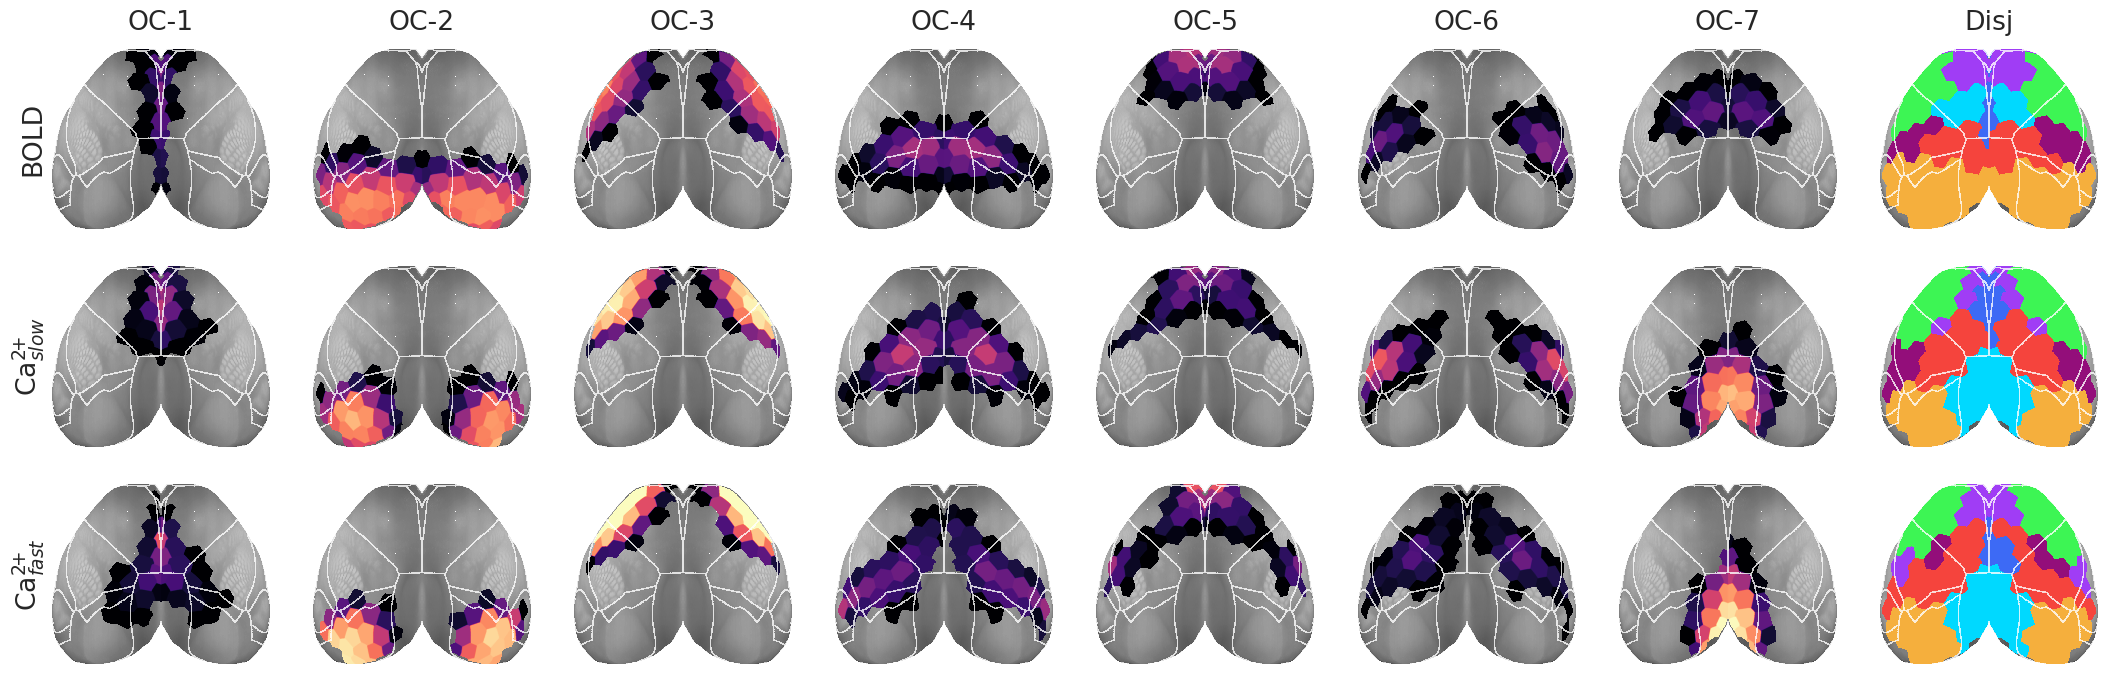

In [8]:
_ = bt.show(
    data={
        mode: avg(o.run_pi) for mode, o
        in results['bt_dict'].items()},
    **show_kws(num_k),
)

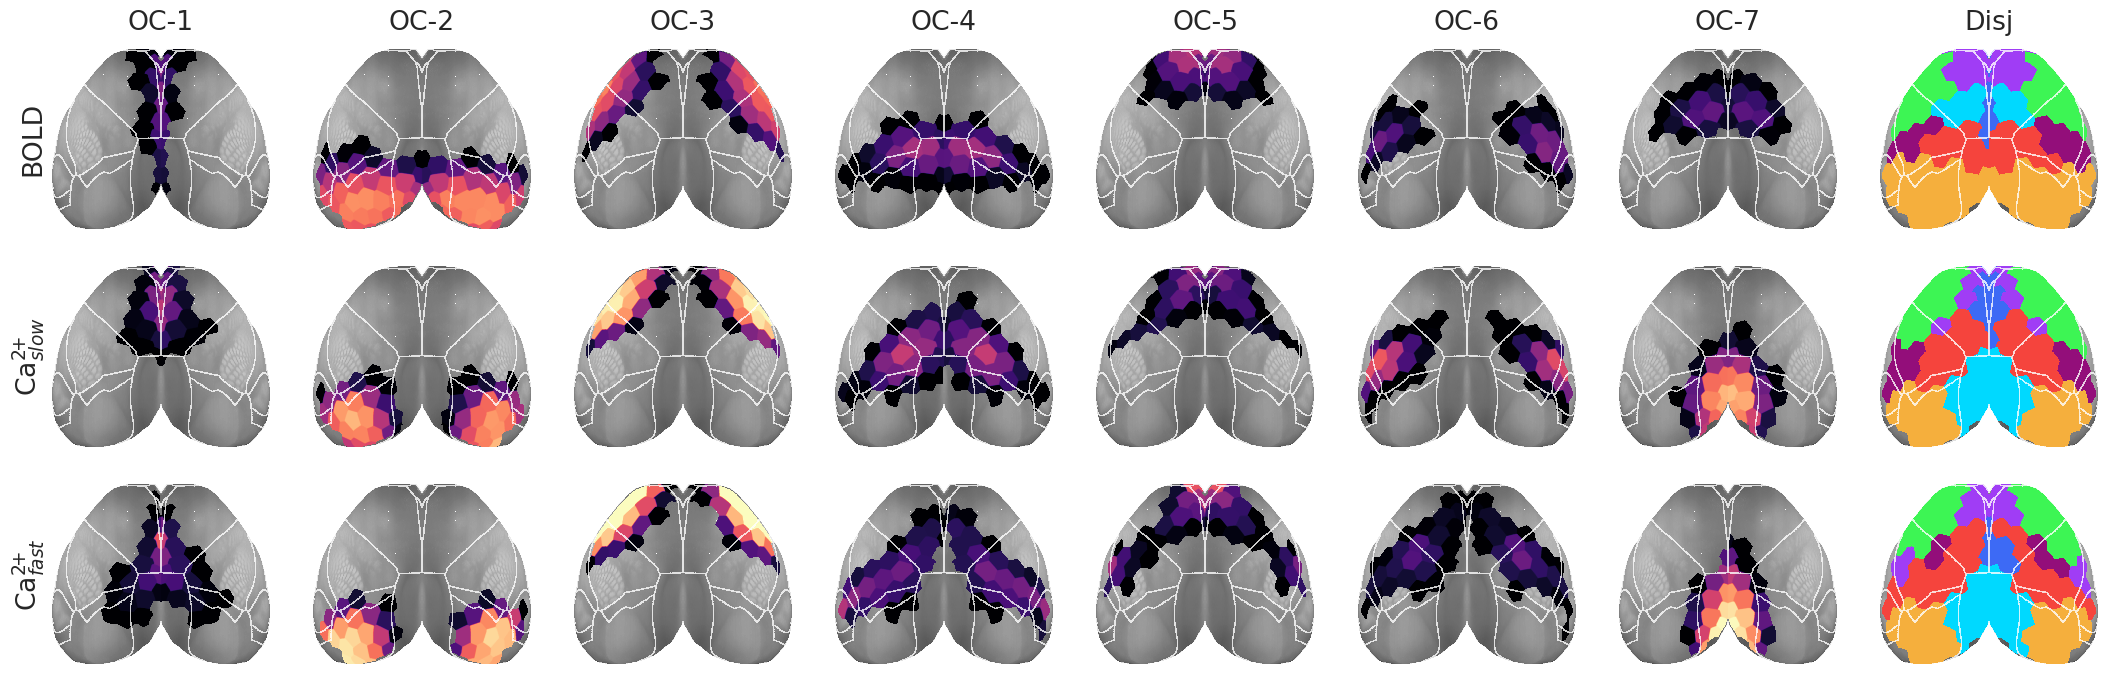

In [9]:
_ = bt.show(results['pi_sorted'], **show_kws(num_k))

### Save Cols & Indiv components

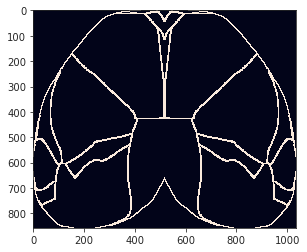

In [10]:
contour = bt.get_contour(0.2, True)
plt.imshow(contour);

In [11]:
from figures.fig_ocs import plot_ocs as go

kwargs = {
    'base': bt,
    'vmin': 0.2,
    'vmax': 0.9,
    'cbar': False,
    'cmap': 'magma',
    'contour': contour,
    'contour_alpha': 0.8,
    'interp': 'antialiased',
    'mask_thres': 1 / num_k,
}
go(
    results['pi_sorted'],
    save_dir=save_dir,
    kws_fig=kws_fig,
    mode2lbl={
        BOLD: 'BOLD',
        CAS: 'CAS',
        CAF: 'CAF'},
    **kwargs,
)

## Similarity plots

### Plot heatmap

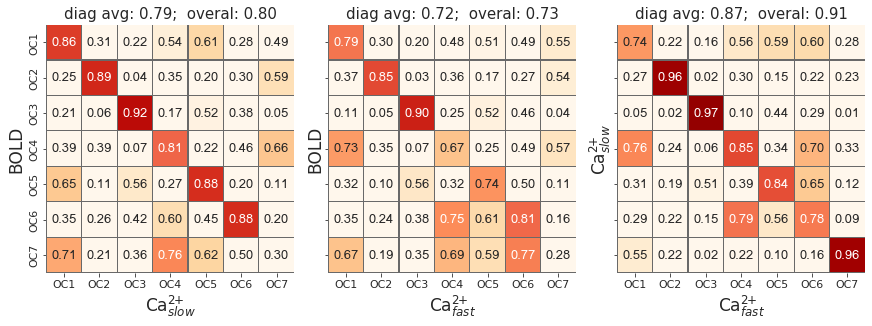

In [12]:
from figures.fig_ocs import similiarity_heatmap as go
_ = go(results['sim'], results['sim_overall'], True, True)
fig, _ = go(results['sim'], results['sim_overall'], False, False)

fig.savefig(pjoin(save_dir, 'sim_hm.pdf'), **kws_fig)
fig.savefig(pjoin(save_dir, 'sim_hm.png'), **kws_fig)

### Plot line

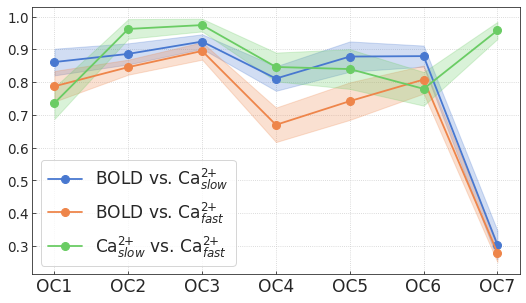

In [13]:
from figures.fig_ocs import similarity_line as go
fig, _ = go(results['sim'], results['sim_b'], True)

fig.savefig(pjoin(save_dir, 'sim_ln.pdf'), **kws_fig)
fig.savefig(pjoin(save_dir, 'sim_ln.png'), **kws_fig)

### Plot point

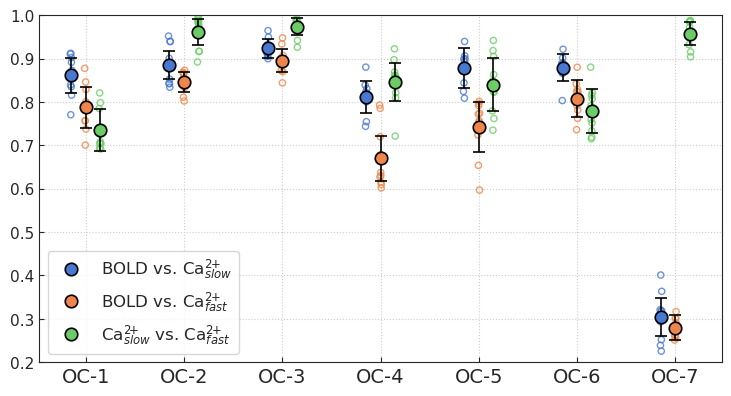

In [14]:
from figures.fig_ocs import similarity_point as go
fig, _ = go(results, False)

fig.savefig(pjoin(save_dir, 'sim_pt.pdf'), **kws_fig)
fig.savefig(pjoin(save_dir, 'sim_pt.png'), **kws_fig)

### Look at boot stuff

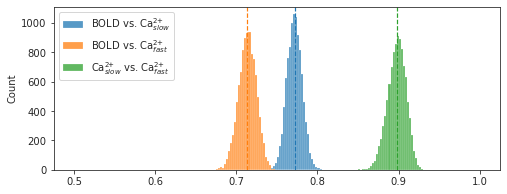

In [15]:
fig, ax = create_figure(1, 1, (8, 3))
for i, ((lbl_1, lbl_2), x) in enumerate(results['sim_overall_b'].items()):
    sns.histplot(
        data=x,
        bins=np.linspace(0.5, 1, 201),
        label=f"{lbl_1} vs. {lbl_2}",
        color=f"C{i}",
        ax=ax
    )
    ax.axvline(x.mean(), color=f"C{i}", ls='--', lw=1.2)
ax.legend()
plt.show()

In [16]:
for k, v in results['sim_overall_b'].items():
    se = np.nanstd(v, 0, ddof=1)
    print(k, se, np.round(se * get_tval(), 3))

('BOLD', 'Ca$^{2\\!\\!+}_{slow}$')
0.009401176155118445 0.021

('BOLD', 'Ca$^{2\\!\\!+}_{fast}$')
0.010785651825621672 0.024

('Ca$^{2\\!\\!+}_{slow}$', 'Ca$^{2\\!\\!+}_{fast}$')
0.011138523426318379 0.025

### Perm test

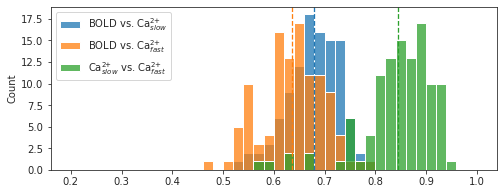

In [17]:
fig, ax = create_figure(1, 1, (8, 3))
for i, ((lbl_1, lbl_2), x) in enumerate(results['data4perm'].items()):
    sns.histplot(
        data=x,
        bins=np.linspace(0.2, 1, 41),
        label=f"{lbl_1} vs. {lbl_2}",
        color=f"C{i}",
        ax=ax,
    )
    ax.axvline(x.mean(), color=f"C{i}", ls='--', lw=1.3)
ax.legend()
plt.show()

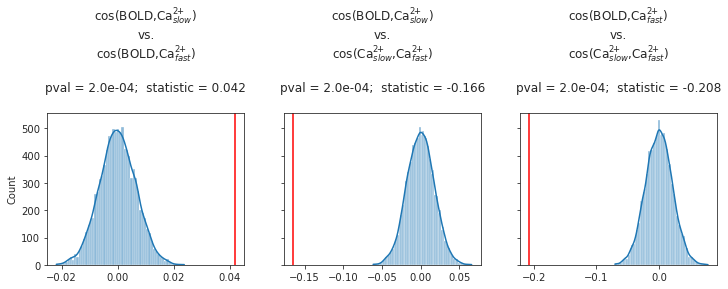

In [18]:
fig, axes = create_figure(1, 3, (12, 2.8), sharey='all')

for i, ((cond_1, cond_2), test) in enumerate(results['tests'].items()):
    ax = axes[i]   
    sns.histplot(test.null_distribution, kde=True, ax=ax)
    ax.axvline(test.statistic, color='r')
    title = f"cos({cond_1[0]},{cond_1[1]})\nvs.\ncos({cond_2[0]},{cond_2[1]})\n\n"
    title += f"pval = {test.pvalue:1.1e};  statistic = {test.statistic:.3f}\n"
    ax.set_title(title)
plt.show()

In [19]:
multipletests([2e-4] * 3, alpha=0.05, method='bonferroni')[0]

array([ True,  True,  True])

---
---

## Choose merge thres

In [20]:
num_k = 7
bt_dict, props_bo, props_ca = default_props(mice, num_k, perc, mg=True)
bt = BootStrap(**props_ca)
bt_dict[BOLD].run_pi.shape

(10, 3, 4, 500, 8, 152)

#### Find best threshold (but remove pi <= 1 / num_k)

In [21]:
%%time

dlist = []
for thres in np.linspace(0.3, 0.5, 101):
    pi, *_ = bt_dict[BOLD].merge_vis(thres, bt_dict[BOLD].run_pi)
    pi = avg(pi)
    pi[pi < 1 / num_k] = 0
    ovp, disj = bt.symmetry_score(pi, decimals=10)
    for lbl, s in {'ovp': ovp, 'disj': disj}.items():
        dlist.append({
            'thres': [thres] * len(s),
            'label': [lbl] * len(s),
            'score': s.values(),
            'oc_idx': s.keys(),
        })
df = pd.DataFrame(merge_dicts(dlist))

CPU times: user 2min 17s, sys: 49.6 s, total: 3min 6s
Wall time: 3min 6s


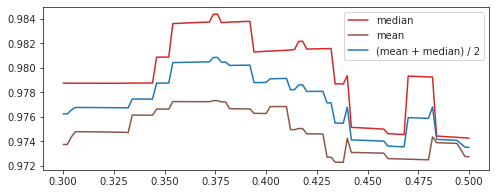

In [22]:
df_mean = df.loc[df['oc_idx'] != -1].groupby(['thres']).mean().drop(columns='oc_idx').reset_index()
df_median = df.loc[df['oc_idx'] != -1].groupby(['thres']).median().drop(columns='oc_idx').reset_index()

fig, ax = create_figure(1, 1, (8, 3))
ax.plot(df_median['thres'], df_median['score'], color='C3', label='median')
ax.plot(df_mean['thres'], df_mean['score'], color='C5', label='mean')

df_mean['score'] = (df_mean['score'] + df_median['score']) / 2
ax.plot(df_mean['thres'], df_mean['score'], color='C0', label='(mean + median) / 2')
ax.legend()
plt.show()

In [23]:
i = df_mean['score'].argmax()
df_mean.iloc[[i]]

,thres,score
38,0.376,0.980849


In [24]:
thres = df_mean.iloc[i]['thres']
thres

0.376

#### Find best threshold

In [25]:
%%time

dlist = []
for thres in np.linspace(0.3, 0.5, 101):
    pi, *_ = bt_dict[BOLD].merge_vis(thres, bt_dict[BOLD].run_pi)
    ovp, disj = bt.symmetry_score(avg(pi), decimals=10)
    for lbl, s in {'ovp': ovp, 'disj': disj}.items():
        dlist.append({
            'thres': [thres] * len(s),
            'label': [lbl] * len(s),
            'score': s.values(),
            'oc_idx': s.keys(),
        })
df = pd.DataFrame(merge_dicts(dlist))

CPU times: user 2min 11s, sys: 46.3 s, total: 2min 58s
Wall time: 2min 58s


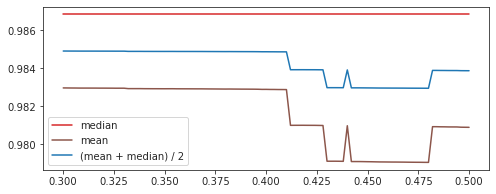

In [26]:
df_mean = df.loc[df['oc_idx'] != -1].groupby(['thres']).mean().drop(columns='oc_idx').reset_index()
df_median = df.loc[df['oc_idx'] != -1].groupby(['thres']).median().drop(columns='oc_idx').reset_index()

fig, ax = create_figure(1, 1, (8, 3))
ax.plot(df_median['thres'], df_median['score'], color='C3', label='median')
ax.plot(df_mean['thres'], df_mean['score'], color='C5', label='mean')

df_mean['score'] = (df_mean['score'] + df_median['score']) / 2
ax.plot(df_mean['thres'], df_mean['score'], color='C0', label='(mean + median) / 2')
ax.legend()
plt.show()

In [27]:
i = df_mean['score'].argmax()
df_mean.iloc[[i]]

,thres,score
0,0.3,0.984901


In [28]:
thres = df_mean.iloc[i]['thres']
thres

0.3

#### Decide which threshold is to be used

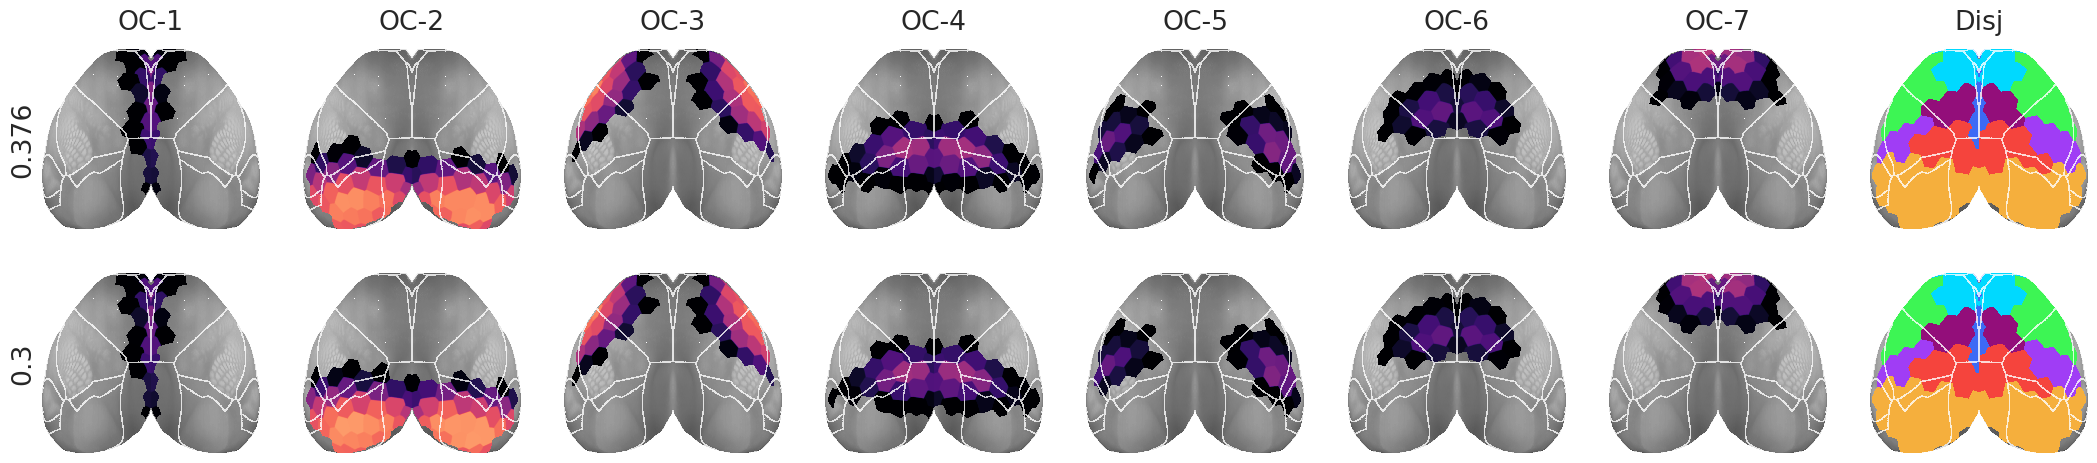

In [29]:
_ = bt.show(
    data={
        th: avg(bt_dict[BOLD].merge_vis(th, bt_dict[BOLD].run_pi)[0])
        for th in [0.376, 0.300]},
    **show_kws(num_k),
)

#### It has been decided: 0.376

In [30]:
thres = 0.376
thres

0.376

In [31]:
o = bt_dict[BOLD]
o.run_pi, *_ = o.merge_vis(thres, o.run_pi)
o.pi_prune, *_ = o.merge_vis(thres, o.pi_prune)
o.num_k -= 1

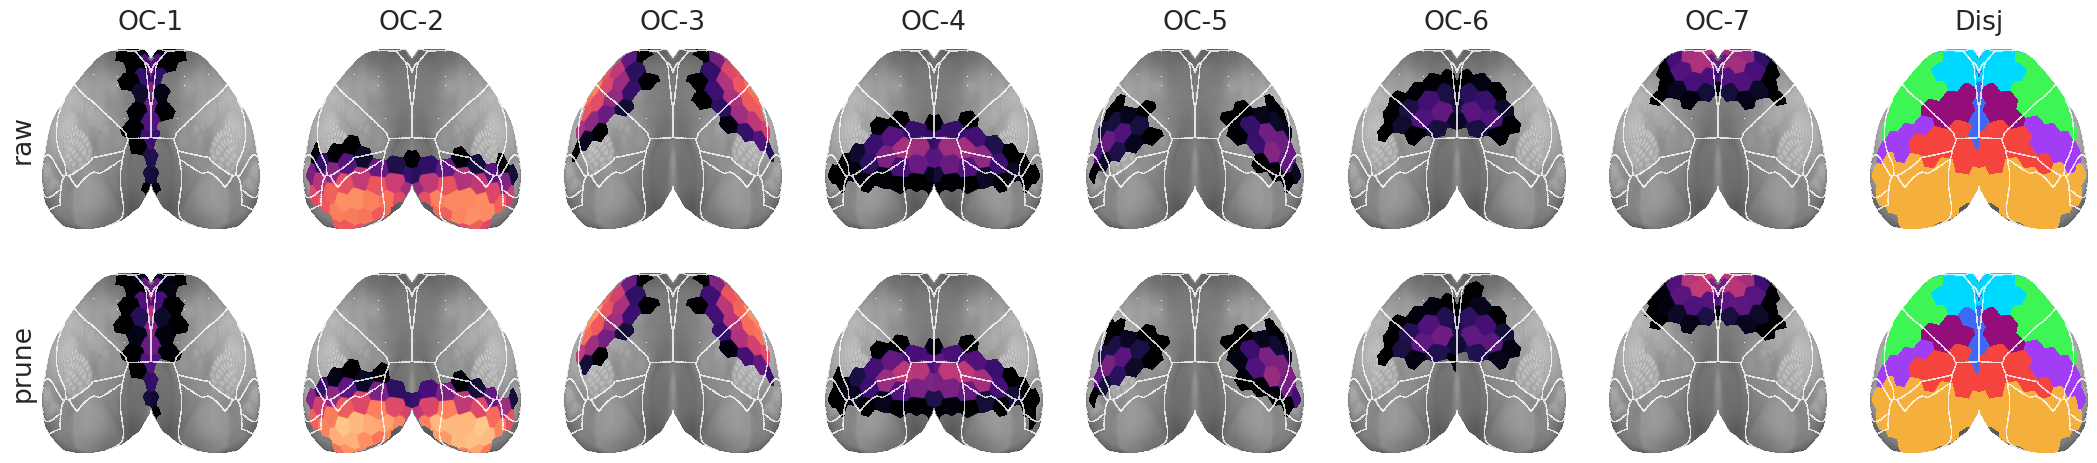

In [32]:
_ = bt.show(data={'raw': avg(o.run_pi), 'prune': avg(o.pi_prune)}, **show_kws(num_k))